In [1]:
import numpy as np
import pandas as pd
from time import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.layers.core import Dropout
from keras.layers import Dense, Embedding, Flatten, LSTM, SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D

from keras.constraints import maxnorm
from keras import regularizers

Using TensorFlow backend.


In [3]:
import py_plots
from py_plots import precisionmeasures as pm

In [4]:
df = pd.read_csv('Final_Balanced_Data.csv')
data = df.dropna()
data.columns = ['labels','tweet','clean_tweet']
max_length = max(data.clean_tweet.apply(lambda sentence: len(sentence.split())))
class_names = ['Hate','Offensive','Neutral']

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data.clean_tweet, data.labels, test_size=0.33, random_state=42)
y_test_cat = to_categorical(y_test)

In [6]:
x_train = x_train.reset_index(drop = True)

In [7]:
vectorizer = TfidfVectorizer(analyzer = 'word')
X_train_tfidf= vectorizer.fit_transform(x_train)
X_test_tfidf = vectorizer.transform(x_test)
y_train_tfidf = y_train
y_test_tfidf = y_test

In [8]:
X_train, x_test, Y_train, y_test = train_test_split(data.clean_tweet, data.labels, test_size=0.33, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)

y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train.append(x_val))
vocab_size = len(tokenizer.word_index)+1
print('Total vocab size: {}'.format(vocab_size))

Total vocab size: 18602


In [10]:
sequence_train = tokenizer.texts_to_sequences(x_train)
padded_train = pad_sequences(sequence_train, maxlen=max_length, padding='post') 

sequence_val = tokenizer.texts_to_sequences(x_val)
padded_val = pad_sequences(sequence_val, maxlen=max_length, padding='post') 

sequence_test = tokenizer.texts_to_sequences(x_test)
padded_test = pad_sequences(sequence_test, maxlen=max_length, padding='post') 

In [11]:
embedding_matrix = pd.read_pickle("GloVe_matrix.pkl").values

In [12]:
def get_model(model_name = 'Hybrid (CNN + LSTM)'):
    if model_name is 'Multilayer Perceptron':
        model = get_MLP()
    elif model_name is 'Convolution Neural Network':
        model = get_CNN()
    elif model_name is 'Long-Short Term Memory Network':
        model = get_LSTM()
    else:
        model = get_hybrid()
    return model

In [13]:
def get_MLP(embed_dim=300):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=max_length, trainable=True))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu',
                           kernel_regularizer=regularizers.l2(0.001),
                           kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(layers.Dense(64,activation='relu',
                           kernel_regularizer=regularizers.l2(0.001),
                           kernel_constraint=maxnorm(3)))
    model.add(layers.Dense(16,activation='relu',
                           kernel_regularizer=regularizers.l2(0.001),
                           kernel_constraint=maxnorm(3)))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
    return model



In [14]:
def get_CNN(embed_dim=300):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=max_length, trainable=True) ) 

    model.add(Conv1D(filters=128, kernel_size=4, activation='relu',kernel_regularizer=regularizers.l2(0.0))) 
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))

    model.add(Conv1D(filters=64, kernel_size=4, activation='relu',kernel_regularizer=regularizers.l2(0.0)))  
    model.add(MaxPooling1D(pool_size=2))


    model.add(Conv1D(filters=32, kernel_size=4, activation='relu',kernel_regularizer=regularizers.l2(0.0)))  
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model

In [15]:
def get_LSTM(embed_dim=300):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=max_length, trainable=True) )
    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(100, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

In [16]:
def get_hybrid(embed_dim=300):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=max_length, trainable=True) )

    model.add(Conv1D(filters=256, kernel_size=4, activation='relu')) 
    model.add(MaxPooling1D(pool_size=2))

    model.add(SpatialDropout1D(0.4))
    model.add(LSTM(256, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    
    return model

In [17]:
def fit_time_score(clf_name):
    model = get_model(clf_name)
    es = EarlyStopping(monitor='val_loss',patience=2)
    t0 = time()
    history = model.fit(padded_train,y_train_onehot,epochs=20,batch_size=128,
                    validation_data=(padded_val, y_val_onehot),
                    callbacks=[es], verbose = 0)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = model.predict(padded_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    y_pred = np.argmax(pred,axis=1)
    y_pred_onehot = to_categorical(y_pred)

    score = f1_score(y_test,y_pred, average="macro")
    print("F1-Score:   %0.3f" % score)
    
    print("classification report:")
    print(classification_report(y_test_onehot, y_pred_onehot,
                                            target_names=class_names))

    print("confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    return clf_name, score, train_time, test_time

In [18]:
# Benchmark classifiers
def benchmark(clf, name):
    print('_' * 80)
    print("Training: ")
    t0 = time()
    clf.fit(X_train_tfidf, y_train_tfidf)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test_tfidf)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    #score = accuracy_score(y_test, pred)
    score = f1_score(y_test,pred, average="macro")
    print("F1-Score:   %0.3f" % score)
    print("classification report:")
    print(classification_report(y_test, pred,
                                            target_names=class_names))

    print("confusion matrix:")
    print(confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


Results = []
for clf, name in (
    (RandomForestClassifier(n_estimators=500, bootstrap=False, max_depth = 100), "Random forest"),
    (GradientBoostingClassifier(n_estimators=800, max_depth = 5),'Gradient Boosting')):
    
    print('=' * 80)
    print(name)
    Results.append(benchmark(clf, name))

NN_names = ['Multilayer Perceptron','Convolution Neural Network',
            'Long-Short Term Memory Network','Hybrid (CNN + LSTM)']
for nn in NN_names:
    print('=' * 80)
    print(nn)
    print('_' * 80)
    Results.append(fit_time_score(nn))


Random forest
________________________________________________________________________________
Training: 
train time: 48.092s
test time:  1.084s
F1-Score:   0.821
classification report:
              precision    recall  f1-score   support

        Hate       0.85      0.69      0.76      2200
   Offensive       0.84      0.91      0.88      2174
     Neutral       0.79      0.88      0.83      2144

    accuracy                           0.82      6518
   macro avg       0.83      0.82      0.82      6518
weighted avg       0.83      0.82      0.82      6518

confusion matrix:
[[1512  268  420]
 [ 103 1978   93]
 [ 166   97 1881]]

Gradient Boosting
________________________________________________________________________________
Training: 
train time: 168.682s
test time:  0.346s
F1-Score:   0.840
classification report:
              precision    recall  f1-score   support

        Hate       0.86      0.70      0.77      2200
   Offensive       0.90      0.89      0.90      2174
     

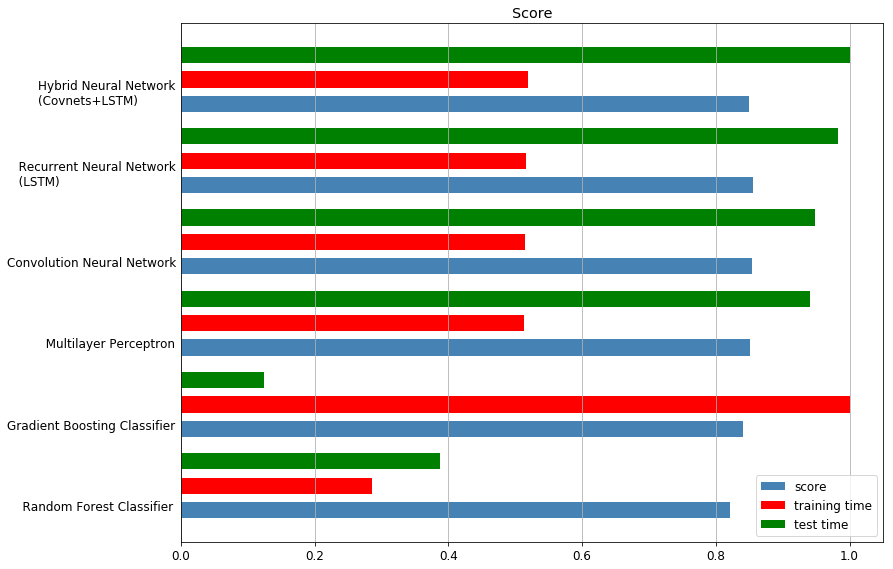

In [19]:
# make some plots
indices = np.arange(len(Results))

results = [[x[i] for x in Results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(15, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='steelblue')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='r')
plt.barh(indices + .6, test_time, .2, label="test time", color='green')
plt.yticks(())
plt.legend(loc='best', fontsize = '12')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

clf_names = ['    Random Forest Classifier',
             'Gradient Boosting Classifier',
            '          Multilayer Perceptron',
             'Convolution Neural Network',
            '   Recurrent Neural Network\n   (LSTM)',
             '        Hybrid Neural Network \n        (Covnets+LSTM)']
for i, c in zip(indices, clf_names):
    plt.text(-.26, i, c)
plt.grid()
plt.show()